### Load liberaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib
import warnings
warnings.filterwarnings("ignore")

### Load cleaned dataset 

In [3]:
# Load dataset
df_cleaned = pd.read_csv('Liver Cirrhosis prediction_Cleaned.csv')

df_cleaned.shape

(9639, 18)

In [4]:
# Explore dataset
df_cleaned.head(10)

,Drug,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,N_Years,Age_years
0,Placebo,F,N,Y,N,N,0.50,149.000000,4.04,178.5,598.000000,52.70,57.000000,256.0,9.9,1.0,6.08,50.65
1,Placebo,M,Y,N,Y,N,0.50,219.000000,3.93,22.0,663.000000,45.00,75.000000,220.0,10.8,2.0,3.37,54.00
2,Placebo,F,N,N,N,N,0.50,320.000000,3.54,51.0,1243.000000,122.45,80.000000,225.0,10.0,2.0,11.46,32.41
3,Placebo,F,N,N,N,N,0.70,255.000000,3.74,23.0,1024.000000,77.50,58.000000,151.0,10.2,2.0,5.72,45.08
4,Placebo,F,N,Y,N,N,1.90,486.000000,3.54,74.0,1052.000000,108.50,109.000000,151.0,11.5,1.0,5.76,59.41
5,Placebo,F,N,N,N,N,1.90,259.000000,3.70,178.5,3410.139422,188.34,173.000000,327.0,10.4,2.0,12.12,44.95
6,Placebo,F,Y,N,Y,N,1.30,291.000000,3.44,75.0,1082.000000,85.00,173.000000,156.0,10.3,2.0,3.88,63.00
7,Placebo,F,Y,N,Y,Y,7.05,200.000000,2.74,140.0,918.000000,147.25,143.000000,150.0,11.1,3.0,0.14,66.00
8,Placebo,F,N,N,N,N,2.30,369.510563,3.93,24.0,1828.000000,133.30,124.702128,474.0,10.9,1.0,6.86,41.79
9,Placebo,M,Y,N,Y,S,1.40,176.000000,3.48,178.5,516.000000,96.10,55.000000,259.0,10.1,3.0,2.77,61.00


In [5]:
print(df_cleaned.dtypes)

Drug              object
Sex               object
Ascites           object
Hepatomegaly      object
Spiders           object
Edema             object
Bilirubin        float64
Cholesterol      float64
Albumin          float64
Copper           float64
Alk_Phos         float64
SGOT             float64
Tryglicerides    float64
Platelets        float64
Prothrombin      float64
Stage            float64
N_Years          float64
Age_years        float64
dtype: object


In [6]:
print(df_cleaned["Stage"].value_counts())

Stage
2.0    3308
3.0    3306
1.0    3025
Name: count, dtype: int64


### Encode data

In [7]:
# Identify numerical and categorical columns
numerical_cols = df_cleaned.select_dtypes(include=['number']).columns
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: Index(['Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT',
       'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage', 'N_Years',
       'Age_years'],
      dtype='object')
Categorical Columns: Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object')


In [8]:
# Encode categorical variables
label_encoders = {}
for col in df_cleaned.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le

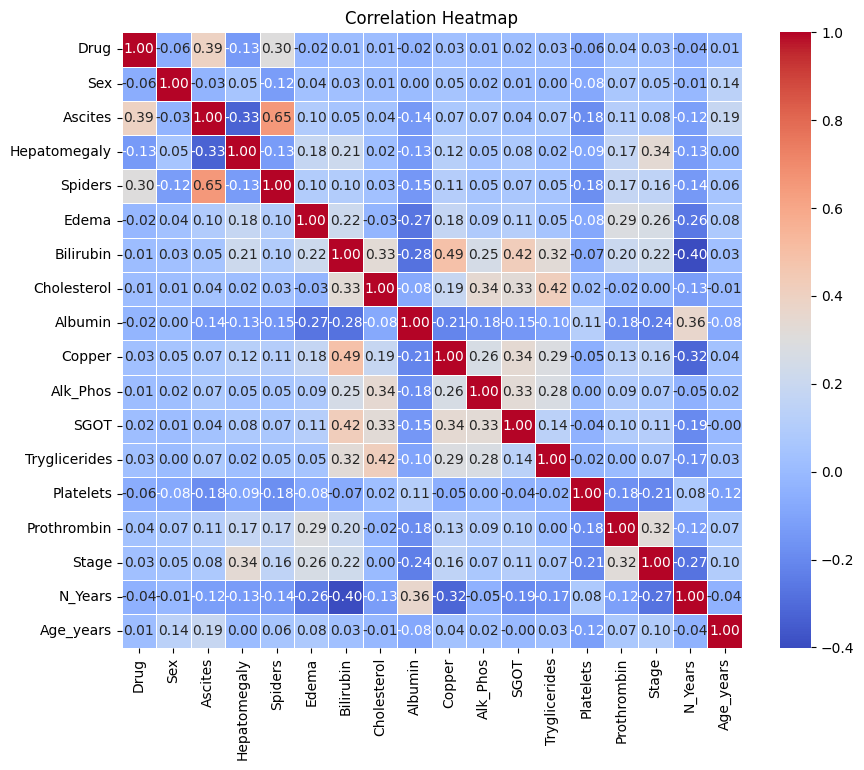

In [9]:
# correlation matrix
corr_matrix = df_cleaned.corr()

# Heat map
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

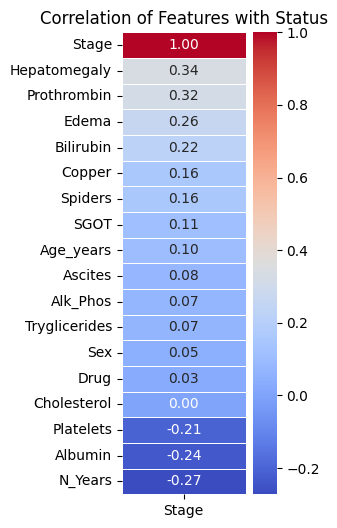

In [10]:
corr_matrix = df_cleaned.corr()
# with target status
corr_status = corr_matrix[["Stage"]].sort_values(by="Stage", ascending=False)
# Heat map
plt.figure(figsize=(2, 6))
sns.heatmap(corr_status, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation of Features with Status")
plt.show()

In [11]:
# low variance columns
low_correlation_features = ["Copper","Spiders","SGOT","Age_years","Ascites","Alk_Phos","Tryglicerides","Sex","Drug","Cholesterol"]
# drop
df_encoded = df_cleaned.drop(columns=low_correlation_features)
print("Remaining columns :", df_encoded.columns.tolist())

Remaining columns : ['Hepatomegaly', 'Edema', 'Bilirubin', 'Albumin', 'Platelets', 'Prothrombin', 'Stage', 'N_Years']


In [13]:
# Save the encoded dataset for modeling
cleaned_file_path = "Liver Cirrhosis_encoded.csv"
df_encoded.to_csv(cleaned_file_path, index=False)

In [14]:
df_encoded.head()

,Hepatomegaly,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage,N_Years
0,1,0,0.5,4.04,256.0,9.9,1.0,6.08
1,0,0,0.5,3.93,220.0,10.8,2.0,3.37
2,0,0,0.5,3.54,225.0,10.0,2.0,11.46
3,0,0,0.7,3.74,151.0,10.2,2.0,5.72
4,1,0,1.9,3.54,151.0,11.5,1.0,5.76


### Model Building ###

In [15]:
# Define features and target
X = df_encoded.drop('Stage', axis=1)
y_raw = df_encoded['Stage']

In [16]:
# Encode the target Stage labels to start from 0
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y_raw)

In [19]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


Training: Random Forest
Best Params: {'model__max_depth': None, 'model__min_samples_split': 5, 'model__n_estimators': 500}
[[511  73  21]
 [ 48 564  50]
 [ 32  40 589]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       605
           1       0.83      0.85      0.84       662
           2       0.89      0.89      0.89       661

    accuracy                           0.86      1928
   macro avg       0.86      0.86      0.86      1928
weighted avg       0.86      0.86      0.86      1928


Training: XGBoost
Best Params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 8, 'model__n_estimators': 300, 'model__subsample': 1.0}
[[544  52   9]
 [ 40 591  31]
 [ 18  33 610]]
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       605
           1       0.87      0.89      0.88       662
           2       0.94      0.92      0.93       661

    accuracy   

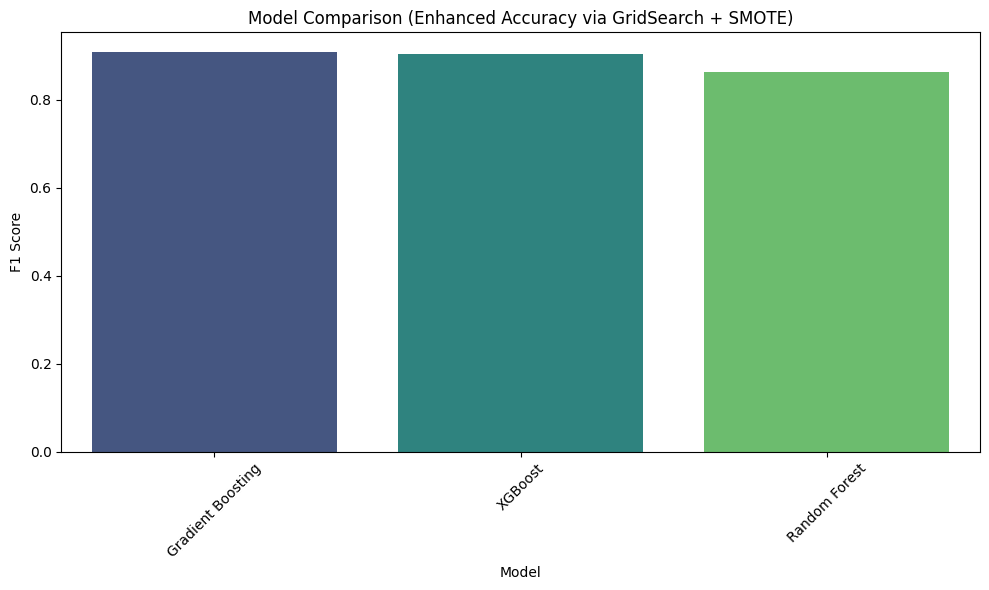

In [20]:
# train random forest classifier, xgboost and Gradient Boosting 

# SMOTE + Scaling + GridSearch Pipeline
models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [100, 300, 500],
            "model__max_depth": [None, 10, 30, 50],
            "model__min_samples_split": [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
        "params": {
            "model__n_estimators": [200, 300],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [4, 6, 8],
            "model__subsample": [0.8, 1.0],
            "model__colsample_bytree": [0.8, 1.0]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(random_state=42),
        "params": {
            "model__n_estimators": [200, 300],
            "model__learning_rate": [0.01, 0.05, 0.1],
            "model__max_depth": [3, 5, 7]
        }
    }
}


results = {}
best_models = {}

for name, config in models_params.items():
    print(f"\nTraining: {name}")
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', config["model"])
    ])

    grid = GridSearchCV(pipeline, config["params"], cv=5, n_jobs=-1, scoring='f1_weighted')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("Best Params:", grid.best_params_)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    results[name] = {"Accuracy": acc, "F1 Score": f1}
    best_models[name] = best_model



# Compare Model Performance
result_df = pd.DataFrame(results).T.sort_values("F1 Score", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=result_df.reset_index(), x="index", y="F1 Score", palette="viridis")
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.title("Model Comparison (Enhanced Accuracy via GridSearch + SMOTE)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

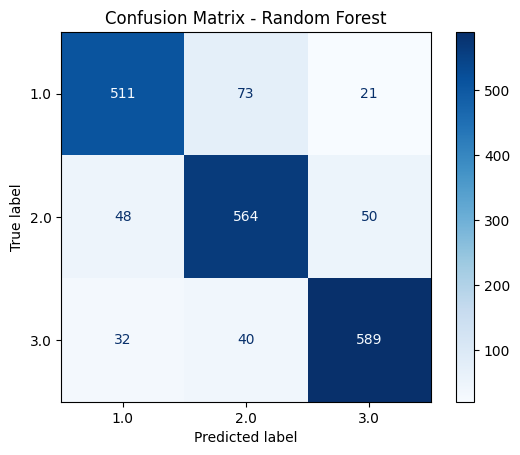

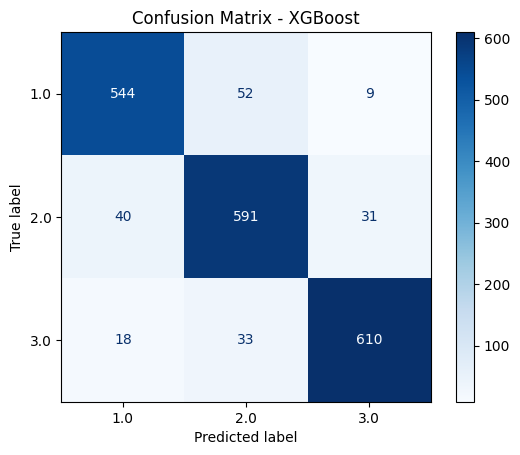

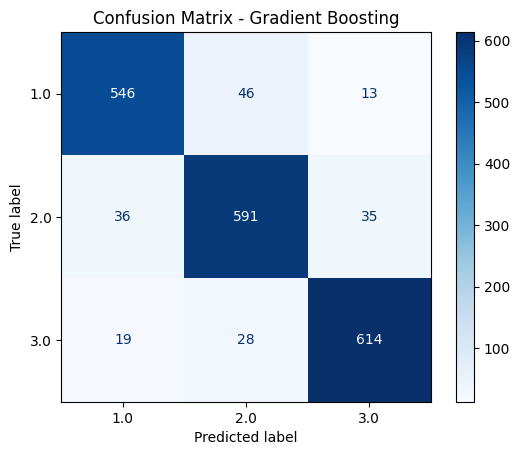

In [22]:
# Plot Confusion Matrices
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_encoder.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

In [34]:
model_name = "Gradient Boosting"
pipeline = best_models[model_name]


scaler = pipeline.named_steps["scaler"]
model = pipeline.named_steps["model"]


joblib.dump(model, f"{model_name}_model.pkl")
print(f"Model saved as {model_name}_model.pkl")


joblib.dump(scaler, "scaler.pkl")
print("Scaler saved as scaler.pkl")


joblib.dump(y_encoder, "label_encoder.pkl")
print("LabelEncoder saved as label_encoder.pkl")

Model saved as Gradient Boosting_model.pkl
Scaler saved as scaler.pkl
LabelEncoder saved as label_encoder.pkl
